<a href="https://colab.research.google.com/github/dblkI/dblki.github.io/blob/main/KLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install rasterio

# Creador de tif


In [176]:
# Instalar dependencias (si no están instaladas)
!pip install pillow rasterio numpy

from PIL import Image
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Paso 1: Leer la imagen PNG
png_path = '/content/heigmap.png'  # Cambia a la ruta de tu archivo PNG
img = Image.open(png_path).convert('L')  # Convertir a escala de grises

# Paso 2: Convertir la imagen a una matriz numpy
img_array = np.array(img)

# Paso 3: Definir las alturas para el valor más blanco (255) y más negro (0)
altura_min = 1382  # Altura para el negro (valor 0)
altura_max = 1667  # Altura para el blanco (valor 255)

# Paso 4: Escalar los valores de grises a alturas
altura_array = np.interp(img_array, (0, 255), (altura_min, altura_max))

# Paso 5: Configurar la transformación geoespacial con latitud y longitud de la esquina inferior izquierda 20.538198, -98.893236
lat_inferior_izquierda = 20.043629  # Cambia a la latitud de la esquina inferior izquierda
long_inferior_izquierda = -99.144715  # Cambia a la longitud de la esquina inferior izquierda

# Definir el tamaño del píxel en grados (resolución espacial). Esto depende de tu imagen.
# Suponiendo que cada píxel cubre 0.001 grados (tanto en latitud como en longitud)
resolucion_x = 0.000004491  # Grados por píxel en longitud (resolución espacial)
resolucion_y = 0.000004491  # Grados por píxel en latitud (resolución espacial)

transform = from_origin(long_inferior_izquierda, lat_inferior_izquierda, resolucion_x, -resolucion_y)

# Paso 6: Crear y guardar el archivo .tif (DEM)
tif_path = '/content/test.tif'  # Cambia a la ruta de tu archivo .tif

with rasterio.open(
    tif_path,
    'w',
    driver='GTiff',
    height=altura_array.shape[0],
    width=altura_array.shape[1],
    count=1,  # Solo una banda para el DEM
    dtype=altura_array.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(altura_array, 1)  # Escribir los datos de altura en el archivo TIFF

print(f'Archivo DEM guardado en {tif_path}')

Archivo DEM guardado en /content/test.tif


# Creador de curvas de nivel

Altura máxima: 1664.764705882353 metros
Altura mínima: 1383.1176470588234 metros


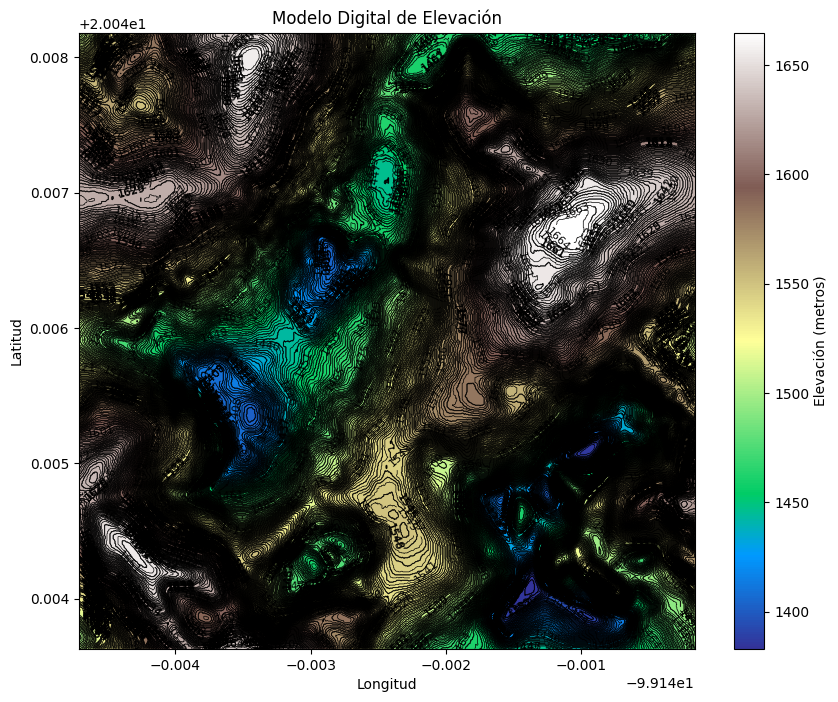

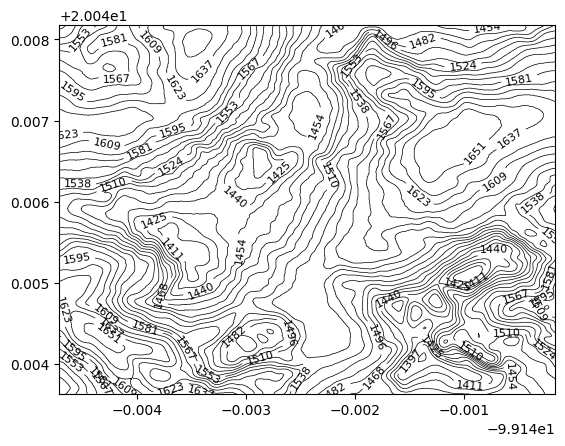

In [184]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import xy

# Abre el archivo .tif que has subido (cambia el nombre del archivo según sea necesario)
file_path = '/content/test.tif'  # Asegúrate de que el nombre y la ruta sean correctos

with rasterio.open(file_path) as dem:
    # Lee los datos del archivo
    dem_data = dem.read(1)  # Leer la primera banda (las elevaciones)

    # Obtiene la altura máxima y mínima
    max_height = dem_data.max()
    min_height = dem_data.min()

    print(f"Altura máxima: {max_height} metros")
    print(f"Altura mínima: {min_height} metros")

    # Obtener la transformación geoespacial (coordenadas de los píxeles)
    transform = dem.transform

    # Crear las coordenadas de los ejes (longitudes y latitudes) basadas en los píxeles
    num_cols, num_rows = dem.width, dem.height
    longitudes = np.linspace(transform[2], transform[2] + transform[0] * num_cols, num_cols)
    latitudes = np.linspace(transform[5], transform[5] + transform[4] * num_rows, num_rows)
    # Visualizar el DEM con latitud y longitud en los ejes
    plt.figure(figsize=(10, 8))
    plt.imshow(dem_data, cmap='terrain', extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()])
    plt.colorbar(label='Elevación (metros)')
    plt.title('Modelo Digital de Elevación')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')


    dem_data_inverted = np.flipud(dem_data)
    num_contours = 400  # Número de niveles de contornos
    levels = np.linspace(dem_data.min(), dem_data.max(), num_contours)
    contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=levels, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
    plt.show()

    selected_levels = levels[::20]  # Esto toma cada décimo nivel
    contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=selected_levels, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
    plt.savefig('contour_plot.png', dpi=300, bbox_inches='tight')  # Guardar como PNG con 300 dpi
    plt.show()

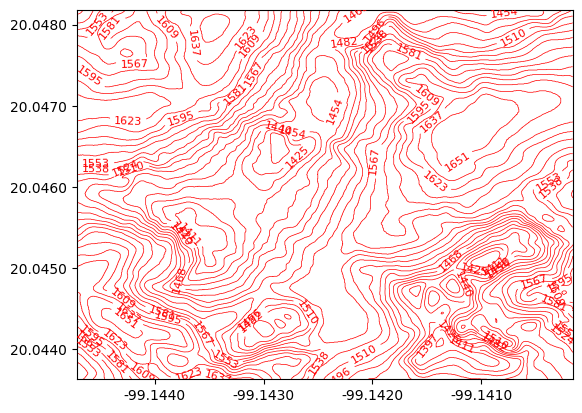

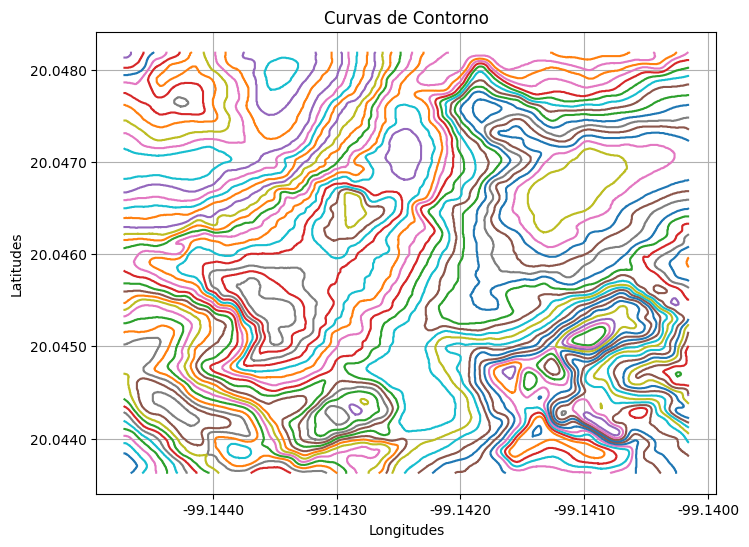

In [199]:
import matplotlib.ticker as ticker
# Extraer las coordenadas de cada contorno y guardarlas
contour_points = {}
for level in selected_levels:
  # Aislar y visualizar solo el contorno específico
  isolating_contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=[level], colors='red', linewidths=0.5)
  plt.clabel(isolating_contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
  # Configurar los ejes para evitar formato científico
  ax = plt.gca()
  ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Formato de dos decimales
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.4f}'))  # Formato de dos decimales

  # Inicializar lista para puntos de este nivel
  contour_points[level] = []
  # Extraer las líneas de contorno
  contour_lines = isolating_contour.allsegs[0]
  for contourt in contour_lines:
    contourt = np.array(contourt)  # Convertir a un arreglo numpy
    x_contour = contourt[:, 0]  # Coordenadas X (longitudes)
    y_contour = contourt[:, 1]  # Coordenadas Y (latitudes)

    # Crear una lista de pares [x, y] y agregarla al diccionario
    points = [[x, y] for x, y in zip(x_contour, y_contour)]
    contour_points[level].append(points)


# Graficar las curvas de los puntos
plt.figure(figsize=(8, 6))
for level, curves in contour_points.items():
    for points in curves:
        # Desempaquetar puntos
        x_vals, y_vals = zip(*points)
        plt.plot(x_vals, y_vals)  # Graficar cada curva


# Configurar los ejes para evitar formato científico
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Formato de dos decimales
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.4f}'))  # Formato de dos decimales

plt.title('Curvas de Contorno')
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.grid()
plt.show()

# Guardar las curvas en un archivo
with open('contour_points.json', 'w') as f:
    json.dump(contour_points, f, indent=4)

# Calculador lokochon

Altura máxima: 1664.764705882353 metros
Altura mínima: 1383.1176470588234 metros
[1383.11764706 1390.33936652 1397.56108597 1404.78280543 1412.00452489
 1419.22624434 1426.4479638  1433.66968326 1440.89140271 1448.11312217
 1455.33484163 1462.55656109 1469.77828054 1477.         1484.22171946
 1491.44343891 1498.66515837 1505.88687783 1513.10859729 1520.33031674
 1527.5520362  1534.77375566 1541.99547511 1549.21719457 1556.43891403
 1563.66063348 1570.88235294 1578.1040724  1585.32579186 1592.54751131
 1599.76923077 1606.99095023 1614.21266968 1621.43438914 1628.6561086
 1635.87782805 1643.09954751 1650.32126697 1657.54298643 1664.76470588]


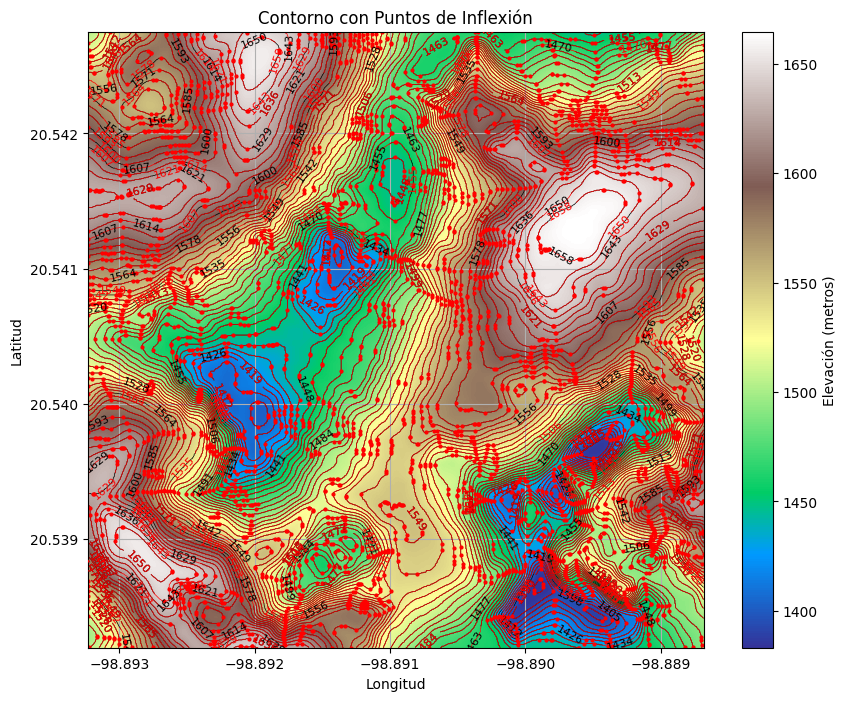

In [160]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import xy
from scipy.signal import find_peaks, savgol_filter
# Abre el archivo .tif que has subido (cambia el nombre del archivo según sea necesario)
file_path = '/content/test.tif'  # Asegúrate de que el nombre y la ruta sean correctos

with rasterio.open(file_path) as dem:
    # Lee los datos del archivo
    dem_data = dem.read(1)  # Leer la primera banda (las elevaciones)
    # Obtiene la altura máxima y mínima
    max_height = dem_data.max()
    min_height = dem_data.min()
    print(f"Altura máxima: {max_height} metros")
    print(f"Altura mínima: {min_height} metros")
    # Obtener la transformación geoespacial (coordenadas de los píxeles)
    transform = dem.transform
    # Crear las coordenadas de los ejes (longitudes y latitudes) basadas en los píxeles
    num_cols, num_rows = dem.width, dem.height
    longitudes = np.linspace(transform[2], transform[2] + transform[0] * num_cols, num_cols)
    latitudes = np.linspace(transform[5], transform[5] + transform[4] * num_rows, num_rows)
    # Visualizar el DEM con latitud y longitud en los ejes
    plt.figure(figsize=(10, 8))
    plt.imshow(dem_data, cmap='terrain', extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()])
    plt.colorbar(label='Elevación (metros)')
    plt.title('Modelo Digital de Elevación')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    # Invertir los datos solo para las curvas de nivel (sin afectar el mapa)
    dem_data_inverted = np.flipud(dem_data)
    # Configurar el rango de contornos (aquí lo hacemos entre el mínimo y máximo de elevación)
    num_contours = 40  # Número de niveles de contornos
    levels = np.linspace(dem_data.min(), dem_data.max(), num_contours)
    contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=levels, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
    print(levels)
    kDotsx=[]
    kDotsy=[]
    poli=1
    window=3
    for level in levels:
      # Aislar y visualizar solo el contorno específico
      isolating_contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=[level], colors='red', linewidths=0.5)
      plt.clabel(isolating_contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
      # Definir el tamaño del filtro FIR y la ventana de suavizado (ventana de Hamming)
      x_contour_list = []
      y_contour_list = []
      contour_lines = isolating_contour.allsegs[0]
      for contourt in contour_lines:

        contourt = np.array(contourt)  # Convertir a un arreglo numpy
        x_contour = contourt[:, 0]  # Coordenadas X (longitudes)
        y_contour = contourt[:, 1]  # Coordenadas Y (latitudes)
        # Suavizar la curva con un filtro de Savitzky-Golay
        x_contour = savgol_filter(x_contour, window_length=window, polyorder=poli)
        y_contour = savgol_filter(y_contour, window_length=window, polyorder=poli)
        # Calcular la derivada primera
        dx = np.gradient(x_contour)
        sdx= savgol_filter(dx, window_length=window, polyorder=poli)
        # Calcular la derivada segunda para detectar inflexiones
        ddx = np.gradient(sdx)
        sddx= savgol_filter(sdx, window_length=window, polyorder=poli)
        # Encontrar los puntos de inflexión donde la derivada segunda cambia de signo
        inflexion_points_x = np.where(np.diff(np.sign(sddx)))[0]

        # Calcular la derivada primera
        dy = np.gradient(y_contour)
        sdy= savgol_filter(dy, window_length=window, polyorder=poli)
        # Calcular la derivada segunda para detectar inflexiones
        ddy = np.gradient(sdy)
        sddy= savgol_filter(sdy, window_length=window, polyorder=poli)
        # Encontrar los puntos de inflexión donde la derivada segunda cambia de signo
        inflexion_points_y = np.where(np.diff(np.sign(sddy)))[0]

        # Agregar los puntos a las listas
        x_contour_list.extend(x_contour[inflexion_points_x])
        x_contour_list.extend(x_contour[inflexion_points_y])
        y_contour_list.extend(y_contour[inflexion_points_x])
        y_contour_list.extend(y_contour[inflexion_points_y])
        plt.plot(x_contour[inflexion_points_x], y_contour[inflexion_points_x], 'ro',markersize=2)
        plt.plot(x_contour[inflexion_points_y], y_contour[inflexion_points_y], 'ro',markersize=2)
        # Etiquetas y leyenda
        plt.title('Contorno con Puntos de Inflexión')
        plt.xlabel('Longitud')
        plt.ylabel('Latitud')
        plt.grid(True)

      #set de instrucciones por nivel
      kDotsx.append(x_contour_list)
      kDotsy.append(y_contour_list)
        # Mostrar gráfico
    plt.show()
    KDOTS=[]
    KDOTS.append(kDotsx)
    KDOTS.append(kDotsy)
    # Reorganización manual de listas
    KDOTS_reorganizado = []

    # Recorremos cada capa
    for i in range(len(KDOTS[0])):  # i es la capa
        capa = []
        # Recorremos cada ID de punto
        for j in range(len(KDOTS[0][i])):  # j es el ID_punto
            # Agrupamos las coordenadas X e Y
            punto = [KDOTS[0][i][j], KDOTS[1][i][j]]
            capa.append(punto)
        KDOTS_reorganizado.append(capa)

    KDOTS=KDOTS_reorganizado

arriba


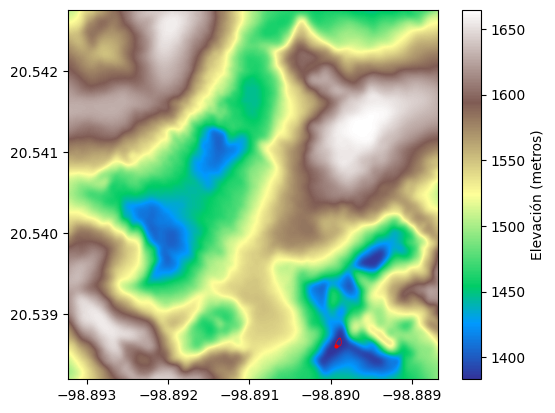

In [168]:
plt.imshow(dem_data, cmap='terrain', extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()])
plt.plot(KDOTS[0][0][0],KDOTS[0][0][1], 'ro',markersize=2)
plt.colorbar(label='Elevación (metros)')
isolating_contour = plt.contour(longitudes, latitudes, dem_data_inverted, levels=[1383.11764706], colors='red', linewidths=0.5)
plt.clabel(isolating_contour, inline=True, fontsize=8, fmt="%1.0f")  # Etiquetas del contorno aislado
# Definir el tamaño del filtro FIR y la ventana de suavizado (ventana de Hamming)
contour_line = isolating_contour.allsegs[0]
contourt = np.array(contour_line[0])  # Convertir a un arreglo numpy
x_contour = contourt[:, 0]  # Coordenadas X (longitudes)
y_contour = contourt[:, 1]  # Coordenadas Y (latitudes)
# Suavizar la curva con un filtro de Savitzky-Golay
x_contour = savgol_filter(x_contour, window_length=window, polyorder=poli)
y_contour = savgol_filter(y_contour, window_length=window, polyorder=poli)
# Puntos a evaluar
point = np.array(KDOTS[0][0])  # Ejemplo de un punto (x, y)
y_curve_at_x = np.interp(point[0], x_contour, y_contour)
if point[1] > y_curve_at_x:
    position = "arriba"
    direction = np.array([0, 1])  # Proyectar hacia arriba
elif point[1] < y_curve_at_x:
    position = "abajo"
    direction = np.array([0, -1])  # Proyectar hacia abajo
elif point[0] > x_contour[-1]:
    position = "derecha"
    direction = np.array([1, 0])  # Proyectar hacia la derecha
else:
    position = "izquierda"
    direction = np.array([-1, 0])  # Proyectar hacia la izquierda
print(position)
# Proyectar una línea en la dirección adecuada
line_start = point
line_end = point + direction * 2  # Alargar la línea


In [117]:
punto_inicial = np.array(KDOTS[38][0])
grupo_sig=np.array(KDOTS[37])

plt.show()

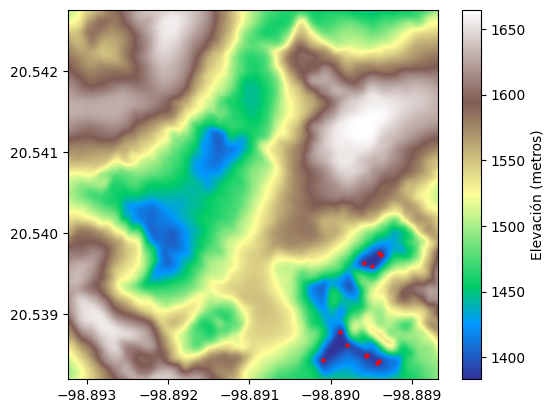

In [41]:
plt.plot(kDotsx[1],kDotsy[1], 'ro',markersize=2)
plt.imshow(dem_data, cmap='terrain', extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()])
plt.colorbar(label='Elevación (metros)')
plt.show()